In [2]:
print ("Behavioural Bias NLP Project Started 🚀")

Behavioural Bias NLP Project Started 🚀


# Behavioral Bias Detection

This notebook builds and evaluates machine learning models to classify financial sentences into behavioral bias categories.


In [3]:
import os

print("Current working directory:")
print(os.getcwd())


Current working directory:
c:\Users\Harshi\Projects\behavioural-bias-nlp\notebooks


In [4]:
#Necessary Imports 

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns


# LOADING A DATASET 

In [5]:
file_path = r"C:\Users\Harshi\Projects\behavioural-bias-nlp\data\Sentences_AllAgree.txt"

import pandas as pd

df = pd.read_csv(
    file_path,
    sep='@',
    header=None,
    names=["sentence", "sentiment"],
    encoding="latin-1"
)

print("Number of rows:", len(df))
df.head()


Number of rows: 2264


,sentence,sentiment
0,"According to Gran , the company has no plans t...",neutral
1,"For the last quarter of 2010 , Componenta 's n...",positive
2,"In the third quarter of 2010 , net sales incre...",positive
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive


In [6]:
df["sentiment"].value_counts()


sentiment
neutral     1391
positive     570
negative     303
Name: count, dtype: int64

In [7]:
def map_bias(sentiment):
    if sentiment == "positive":
        return "Overconfidence"
    elif sentiment == "negative":
        return "Loss_Aversion"
    else:
        return "Rational"

df["bias"] = df["sentiment"].apply(map_bias)

df.head()


,sentence,sentiment,bias
0,"According to Gran , the company has no plans t...",neutral,Rational
1,"For the last quarter of 2010 , Componenta 's n...",positive,Overconfidence
2,"In the third quarter of 2010 , net sales incre...",positive,Overconfidence
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive,Overconfidence
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive,Overconfidence


In [8]:
df["bias"].value_counts()


bias
Rational          1391
Overconfidence     570
Loss_Aversion      303
Name: count, dtype: int64

In [9]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 2264 entries, 0 to 2263
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   sentence   2264 non-null   str  
 1   sentiment  2264 non-null   str  
 2   bias       2264 non-null   str  
dtypes: str(3)
memory usage: 361.8 KB


In [10]:
df.describe()

,sentence,sentiment,bias
count,2264,2264,2264
unique,2259,3,3
top,The issuer is solely responsible for the conte...,neutral,Rational
freq,2,1391,1391


In [11]:
#Handling Missing Values

df.isnull().sum()


sentence     0
sentiment    0
bias         0
dtype: int64

## EXPLORATION OF DATASET 

<Axes: >

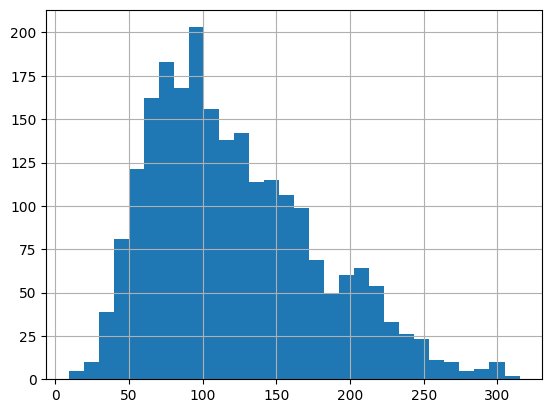

In [12]:
# Checking for long sentences in the dataset

df["length"] = df["sentence"].apply(len)
df["length"].hist(bins=30)


## TRAIN-TEST SPLIT

In [13]:

from sklearn.model_selection import train_test_split

X = df["sentence"]
y = df["bias"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))


Train size: 1811
Test size: 453


## TEXT PREPROCESSING

In [14]:
# Convert Text to Numerical Features 

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    stop_words="english",
    max_features=20000,
    ngram_range=(1, 3)  
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("New feature shape:", X_train_tfidf.shape)



New feature shape: (1811, 20000)


## MODEL TRAINING 

In [15]:
#MODEL 1. LOGISTIC REGRESSION

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression(
    C=30,
    max_iter=2000,
    class_weight="balanced"
)

model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred))



Accuracy: 0.8962472406181016
                precision    recall  f1-score   support

 Loss_Aversion       0.85      0.77      0.81        61
Overconfidence       0.77      0.88      0.82       114
      Rational       0.97      0.93      0.95       278

      accuracy                           0.90       453
     macro avg       0.86      0.86      0.86       453
  weighted avg       0.90      0.90      0.90       453



In [16]:
print(y_train.value_counts(normalize=True))


bias
Rational          0.614578
Overconfidence    0.251795
Loss_Aversion     0.133628
Name: proportion, dtype: float64


In [17]:
# Why Logostic Regression?

#1. Works extremely well with TF-IDF
#2. Handles high-dimensional sparse features
#3. Interpretable (you can inspect word coefficients)

In [18]:
#MODEL 2: MULTINOMIAL NAIVE BAYES

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

nb_pred = nb_model.predict(X_test_tfidf)

print("Naive Bayes Accuracy:", accuracy_score(y_test, nb_pred))


Naive Bayes Accuracy: 0.7858719646799117


In [19]:
#Why Multinomial Naive Bayes?

#1. Specifically designed for text data

#2. Based on word frequency probabilities
#3. Very fast
#4. Works surprisingly well on small datasets
#5. It assumes word independence (not fully true) — but in NLP it performs strongly.

In [20]:
#MODEL 3 : LINEAR SVM

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Build pipeline (vectorizer + model together)
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1,2),
        max_features=10000
    )),
    ("svm", LinearSVC(C=1))
])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    pipeline,
    df["sentence"],   # raw text
    df["bias"],       # target
    cv=skf,
    scoring="f1_macro"
)

print("F1 Macro scores:", cv_scores)
print("Average F1 Macro:", cv_scores.mean())



F1 Macro scores: [0.87216231 0.87766009 0.83454573 0.8132925  0.85561087]
Average F1 Macro: 0.8506542997079295


In [21]:
# Why Linear SVM?

#1. Handles high-dimensional sparse data extremely well
#2. Often outperforms logistic regression in text tasks
#3. Strong margin-based classifier

## MODEL COMPARISON 

In [22]:

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "Logistic Regression": LogisticRegression(C=10, max_iter=2000),
    "Naive Bayes": MultinomialNB(),
    "Linear SVM": LinearSVC(C=1)
}

for name, model in models.items():
    
    pipeline = Pipeline([
        ("tfidf", TfidfVectorizer(
            ngram_range=(1,2),
            max_features=10000
        )),
        ("model", model)
    ])
    
    scores = cross_val_score(
        pipeline,
        df["sentence"],
        df["bias"],
        cv=skf,
        scoring="f1_macro"
    )
    
    print(f"{name}:")
    print("  Fold Scores:", np.round(scores, 3))
    print("  Avg Macro F1:", round(scores.mean(), 3))
    print("-" * 40)


Logistic Regression:
  Fold Scores: [0.835 0.86  0.835 0.815 0.854]
  Avg Macro F1: 0.84
----------------------------------------
Naive Bayes:
  Fold Scores: [0.575 0.573 0.583 0.615 0.588]
  Avg Macro F1: 0.587
----------------------------------------
Linear SVM:
  Fold Scores: [0.872 0.878 0.835 0.813 0.856]
  Avg Macro F1: 0.851
----------------------------------------


## FINAL TRAINING 

In [23]:

final_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1,2),
        max_features=10000
    )),
    ("model", LinearSVC(C=1))
])

final_pipeline.fit(df["sentence"], df["bias"])


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('tfidf', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (string transformation) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None


In [24]:
import numpy as np

feature_names = final_pipeline.named_steps["tfidf"].get_feature_names_out()
coefficients = final_pipeline.named_steps["model"].coef_

for i, class_label in enumerate(final_pipeline.named_steps["model"].classes_):
    top10 = np.argsort(coefficients[i])[-10:]
    print(f"\nTop words for {class_label}:")
    print([feature_names[j] for j in top10])



Top words for Loss_Aversion:
['fell to', 'fall', 'declined', 'lower', 'dropped', 'decreased to', 'down from', 'fell', 'decreased', 'down']

Top words for Overconfidence:
['won', 'rose to', 'positive', 'improved', 'up from', 'increase', 'up', 'grew', 'rose', 'increased']

Top words for Rational:
['includes', 'will be', 'range', 'the', 'and', 'approximately', 'profit eur', 'be', 'mn and', 'is']


In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


                precision    recall  f1-score   support

 Loss_Aversion       0.85      0.77      0.81        61
Overconfidence       0.77      0.88      0.82       114
      Rational       0.97      0.93      0.95       278

      accuracy                           0.90       453
     macro avg       0.86      0.86      0.86       453
  weighted avg       0.90      0.90      0.90       453



## CONFUSION MATRIX 

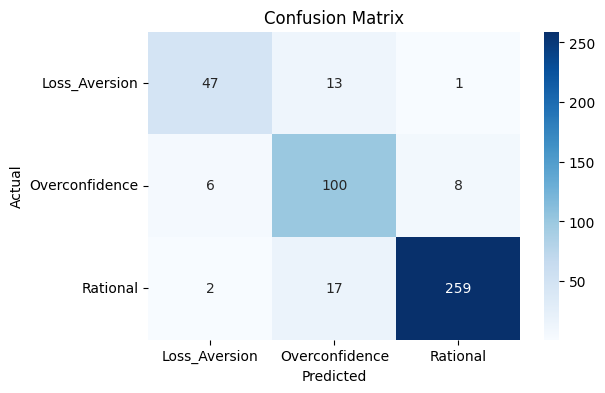

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

labels = sorted(y_test.unique())

cm = confusion_matrix(y_test, y_pred, labels=labels)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Hyperparameter Optimization using GridSearchCV

In this section, we perform systematic hyperparameter tuning for the Linear SVM model using Stratified 5-Fold Cross Validation.
Evaluation metric: Macro F1 Score.


In [27]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer

# Create pipeline (vectorizer + classifier together)
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('svm', LinearSVC(class_weight='balanced'))
])

print("Pipeline created successfully.")


Pipeline created successfully.


In [28]:
# Define hyperparameter grid

param_grid = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__max_features': [5000, 10000, 15000],
    'svm__C': [0.1, 1, 5, 10, 30, 50]
}

print("Parameter grid defined.")


Parameter grid defined.


In [29]:
# Stratified 5-Fold Cross Validation

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

print("Stratified K-Fold defined.")


Stratified K-Fold defined.


In [30]:
# Initialize GridSearch
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=cv,
    scoring='f1_macro',
    n_jobs=-1   # uses all CPU cores
)

print("Starting GridSearch...")

# IMPORTANT: Use RAW text, not TF-IDF transformed data
grid_search.fit(X_train, y_train)

print("GridSearch completed.")



Starting GridSearch...
GridSearch completed.


In [31]:
print("Best Parameters Found:")
print(grid_search.best_params_)

print("\nBest Cross-Validated Macro F1:")
print(round(grid_search.best_score_, 4))


Best Parameters Found:
{'svm__C': 10, 'tfidf__max_features': 10000, 'tfidf__ngram_range': (1, 2)}

Best Cross-Validated Macro F1:
0.7756


In [32]:
# Get best model
best_model = grid_search.best_estimator_

# Predict on test set
y_pred_tuned = best_model.predict(X_test)

from sklearn.metrics import classification_report

print("Test Set Classification Report (Tuned Model):")
print(classification_report(y_test, y_pred_tuned))


Test Set Classification Report (Tuned Model):
                precision    recall  f1-score   support

 Loss_Aversion       0.80      0.74      0.77        61
Overconfidence       0.76      0.84      0.80       114
      Rational       0.95      0.93      0.94       278

      accuracy                           0.88       453
     macro avg       0.84      0.84      0.84       453
  weighted avg       0.88      0.88      0.88       453



## Model Explainability using SHAP (Logistic Regression)


To better understand how the model makes predictions, SHAP (SHapley Additive exPlanations) was used to analyze feature-level contributions.

SHAP assigns an importance value to each word in a sentence, indicating how strongly it pushes the prediction toward a particular behavioral bias.

**How to Read the SHAP Summary Plots**
Each dot represents a word occurrence in the dataset.
The horizontal position shows how strongly that word influences the prediction.
Words on the right side increase the probability of that class.
Words on the left side decrease the probability of that class.
The color represents how frequently that word appears (red = higher value, blue = lower value).

In [33]:
from sklearn.linear_model import LogisticRegression

# Create Logistic Regression pipeline
logreg_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        stop_words='english',
        ngram_range=(1,2),
        max_features=10000
    )),
    ('logreg', LogisticRegression(
        C=10,
        max_iter=2000,
        class_weight='balanced'
    ))
])

# Train on full training set
logreg_pipeline.fit(X_train, y_train)

print("Logistic Regression model trained for SHAP.")


Logistic Regression model trained for SHAP.


In [34]:
import shap

# Extract trained components
vectorizer = logreg_pipeline.named_steps['tfidf']
model = logreg_pipeline.named_steps['logreg']

# Transform training data into TF-IDF matrix
X_train_tfidf = vectorizer.transform(X_train)

print("TF-IDF transformation complete.")


TF-IDF transformation complete.


In [35]:
# Initialize SHAP Linear Explainer

explainer = shap.LinearExplainer(model, X_train_tfidf)

print("SHAP explainer created.")


SHAP explainer created.


In [36]:
# Compute SHAP values on test data

X_test_tfidf = vectorizer.transform(X_test)

shap_values = explainer.shap_values(X_test_tfidf)

print("SHAP values computed.")


SHAP values computed.


In [37]:
print(type(shap_values))
print(np.array(shap_values).shape)


<class 'numpy.ndarray'>
(453, 10000, 3)



SHAP Summary for class: Loss_Aversion


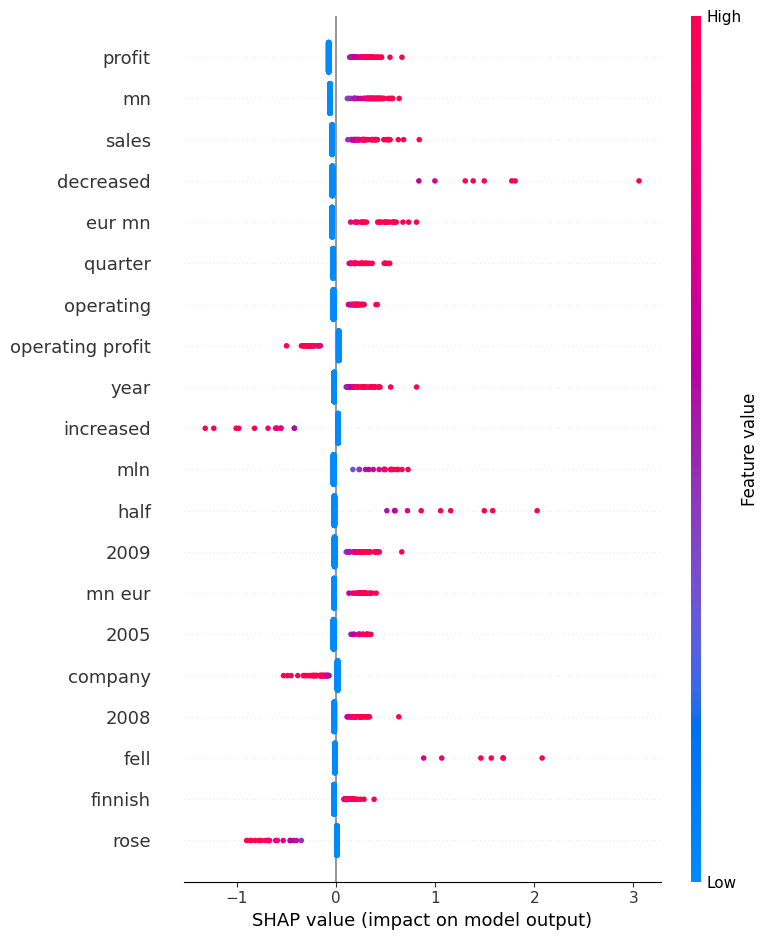


SHAP Summary for class: Overconfidence


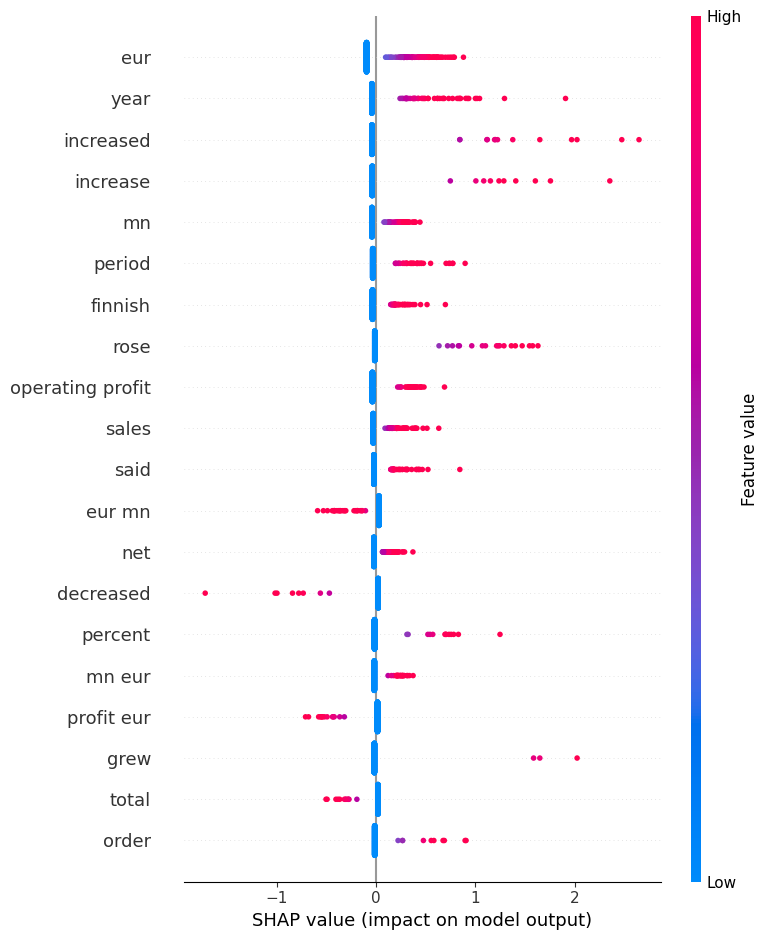


SHAP Summary for class: Rational


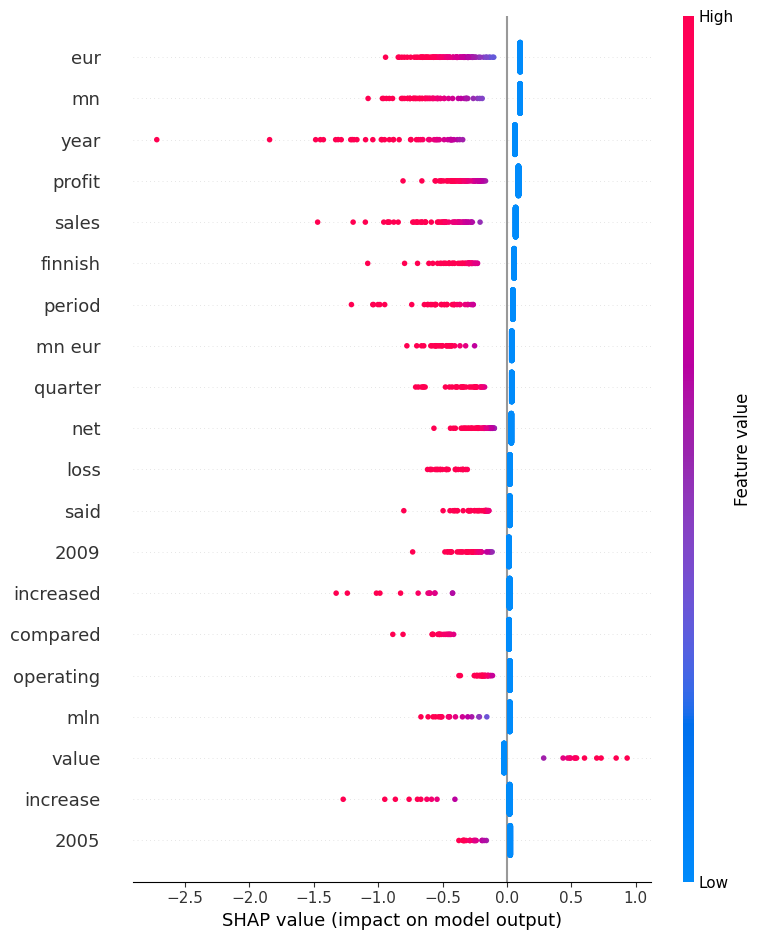

In [38]:
feature_names = vectorizer.get_feature_names_out()
X_test_dense = X_test_tfidf.toarray()

for i, class_name in enumerate(model.classes_):
    print(f"\nSHAP Summary for class: {class_name}")
    
    shap.summary_plot(
        shap_values[:, :, i],   # slice class dimension
        X_test_dense,
        feature_names=feature_names,
        show=True
    )


## 1.Loss Aversion

The model identifies words associated with negative financial outcomes (e.g., decline, loss, decrease, weak, lower) as strong indicators of Loss Aversion.

This aligns with behavioral finance theory, where investors exhibit stronger reactions to losses than gains.

The SHAP analysis confirms that the model captures negative framing and downside-focused language patterns.

## 2.Overconfidence

Words suggesting strong positive performance or forward-looking optimism (e.g., growth, strong, significant increase, expansion, improved) contribute positively toward Overconfidence classification.

This reflects the behavioral tendency to overestimate future performance or interpret results with excessive optimism.

The model successfully distinguishes assertive growth language from neutral reporting.

## 3.Rational Behavior

The Rational class is primarily driven by neutral, factual, and descriptive financial reporting terms (e.g., reported, company, quarter, revenue).

These words do not express strong positive or negative emotion but instead reflect objective communication.

This demonstrates that the model differentiates emotional bias from neutral financial language.

## Transformer Model: DistilBERT Fine-Tuning

In this section, we fine-tune a pre-trained DistilBERT model for 3-class behavioral bias classification.


In [39]:
import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder

print("Libraries imported successfully.")


Libraries imported successfully.


In [40]:
# Encode text labels into integers

label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

print("Encoded Classes:", label_encoder.classes_)


Encoded Classes: ['Loss_Aversion' 'Overconfidence' 'Rational']


In [41]:
# Create train and test datasets
train_dataset = Dataset.from_dict({
    "text": list(X_train),
    "label": list(y_train_encoded)
})

test_dataset = Dataset.from_dict({
    "text": list(X_test),
    "label": list(y_test_encoded)
})

print("Datasets created successfully.")
print(train_dataset)


Datasets created successfully.
Dataset({
    features: ['text', 'label'],
    num_rows: 1811
})


In [42]:
# Load DistilBERT tokenizer

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

print("Tokenizer loaded.")


Tokenizer loaded.


In [43]:
# Tokenization function

def tokenize(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

# Apply tokenization
train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

# Set format for PyTorch

train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

print("Tokenization complete.")


Map:   0%|          | 0/1811 [00:00<?, ? examples/s]

Map:   0%|          | 0/453 [00:00<?, ? examples/s]

Tokenization complete.


In [44]:
# Load pre-trained DistilBERT for 3-class classification

model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=3
)

print("Model loaded successfully.")


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_projector.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
pre_classifier.bias     | MISSING    | 
classifier.bias         | MISSING    | 
classifier.weight       | MISSING    | 
pre_classifier.weight   | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Model loaded successfully.


In [45]:
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_steps=50,
    save_strategy="no",
    report_to="none"
)

print("Training arguments set successfully.")


Training arguments set successfully.


In [46]:
import numpy as np
from sklearn.metrics import f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return {
        "macro_f1": f1_score(labels, predictions, average="macro")
    }

print("Metric function ready.")


Metric function ready.


In [47]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

print("Starting training...")
trainer.train()


Starting training...


c:\Users\Harshi\Projects\behavioural-bias-nlp\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Step,Training Loss
50,0.635626
100,0.264227
150,0.180774
200,0.177955
250,0.144470
300,0.071555
350,0.152016
400,0.041140
450,0.079867


TrainOutput(global_step=454, training_loss=0.1924963234862239, metrics={'train_runtime': 1183.7925, 'train_samples_per_second': 3.06, 'train_steps_per_second': 0.384, 'total_flos': 119951368607232.0, 'train_loss': 0.1924963234862239, 'epoch': 2.0})

In [48]:
results = trainer.evaluate()
print(results)


{'eval_loss': 0.1292657107114792, 'eval_macro_f1': 0.9604904439275964, 'eval_runtime': 35.7348, 'eval_samples_per_second': 12.677, 'eval_steps_per_second': 1.595, 'epoch': 2.0}


In [49]:
# Get predictions

predictions_output = trainer.predict(test_dataset)

logits = predictions_output.predictions
y_pred_transformer = np.argmax(logits, axis=1)

print("Predictions generated.")


c:\Users\Harshi\Projects\behavioural-bias-nlp\venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Predictions generated.


## CONFUSION MATRIX

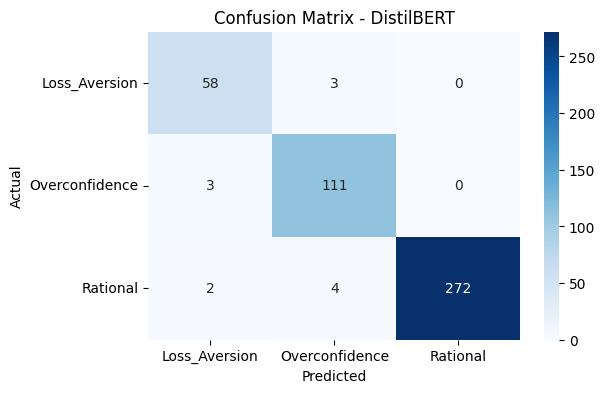

In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred_transformer)

# Plot
plt.figure(figsize=(6,4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - DistilBERT")
plt.show()


## CLASSIFICATION REPORT 

In [51]:
from sklearn.metrics import classification_report

print("DistilBERT Classification Report:\n")

print(classification_report(
    y_test_encoded,
    y_pred_transformer,
    target_names=label_encoder.classes_
))


DistilBERT Classification Report:

                precision    recall  f1-score   support

 Loss_Aversion       0.92      0.95      0.94        61
Overconfidence       0.94      0.97      0.96       114
      Rational       1.00      0.98      0.99       278

      accuracy                           0.97       453
     macro avg       0.95      0.97      0.96       453
  weighted avg       0.97      0.97      0.97       453



## INFERENCE DEMO

In [52]:
def predict_bias(text):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=128
    )
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    logits = outputs.logits
    prediction = torch.argmax(logits, dim=1).item()
    
    return label_encoder.inverse_transform([prediction])[0]


# Try examples
example_1 = "The company expects strong growth and significant expansion next quarter."
example_2 = "Investors are worried about declining revenues and potential losses."
example_3 = "The company reported quarterly earnings in line with expectations."

print("Example 1 Prediction:", predict_bias(example_1))
print("Example 2 Prediction:", predict_bias(example_2))
print("Example 3 Prediction:", predict_bias(example_3))


Example 1 Prediction: Overconfidence
Example 2 Prediction: Loss_Aversion
Example 3 Prediction: Rational
